In [1]:
from saasbo import run_saasbo
import math
import jax.numpy as jnp
import numpy as np

In [2]:
lb = np.hstack((-5 * np.ones(50), 0 * np.ones(50)))   # lower bounds for input domain
ub = np.hstack((10 * np.ones(50), 15 * np.ones(50)))  # upper bounds for input domain

def branin100(x):
    assert (x <= ub).all() and (x >= lb).all()
    x1, x2 = x[19], x[64]  # Only dimensions 19 and 64 affect the value of the function
    t1 = x2 - 5.1 / (4 * math.pi ** 2) * x1 ** 2 + 5 / math.pi * x1 - 6
    t2 = 10 * (1 - 1 / (8 * math.pi)) * np.cos(x1)
    return t1 ** 2 + t2 + 10

In [3]:
X, Y = run_saasbo(
    f=branin100,        # function to be minimized
    lb=lb,              # lower bounds
    ub=ub,              # upper bounds
    max_evals=50,       # total evaluation budget
    num_init_evals=10,  # number of initial quasi-random Sobol points
    seed=0,             # controls the seed for the num_init_evals random points
    alpha=0.1,          # controls sparsity in the SAAS prior
    num_warmup=512,     # number of warmup samples used in HMC
    num_samples=256,    # number of post-warmup samples used in HMC
    thinning=16,        # whether to thin the post-warmup samples by some factor
    num_restarts_ei=3,  # number of restarts for EI maximization
    kernel="rbf",       # "rbf" or "matern"
    device="cpu",       # "cpu" or "gpu"
)

Starting SAASBO optimization run.
First 10 queries drawn at random. Best minimum thus far: 4.320
=== Iteration 10 ===
GP fitting took 6.19 seconds
Optimizing EI took 31.94 seconds
Observed function value: 43.118, Best function value seen thus far: 4.320
=== Iteration 11 ===
GP fitting took 4.50 seconds
Optimizing EI took 32.35 seconds
Observed function value: 176.502, Best function value seen thus far: 4.320
=== Iteration 12 ===
GP fitting took 5.15 seconds
Optimizing EI took 41.86 seconds
Observed function value: 19.761, Best function value seen thus far: 4.320
=== Iteration 13 ===
GP fitting took 5.30 seconds
Optimizing EI took 41.54 seconds
Observed function value: 8.311, Best function value seen thus far: 4.320
=== Iteration 14 ===
GP fitting took 5.55 seconds
Optimizing EI took 51.29 seconds
Observed function value: 20.149, Best function value seen thus far: 4.320
=== Iteration 15 ===
GP fitting took 5.58 seconds
Optimizing EI took 37.44 seconds
Observed function value: 28.316, Be

## Plot progress

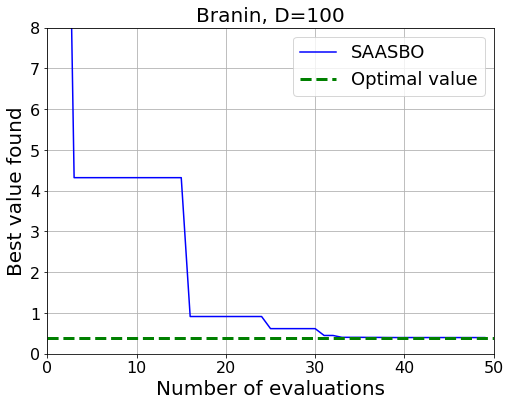

In [4]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
matplotlib.rcParams.update({"font.size": 16})


fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(np.minimum.accumulate(Y), color="b", label="SAASBO")
ax.plot([0, 50], [0.398, 0.398], "--", c="g", lw=3, label="Optimal value")
ax.grid(True)
ax.set_title("Branin, D=100", fontsize=20)
ax.set_xlabel("Number of evaluations", fontsize=20)
ax.set_xlim([0, 50])
ax.set_ylabel("Best value found", fontsize=20)
ax.set_ylim([0, 8])
ax.legend(fontsize=18)
plt.show()

## Take a look at the GP fit

In [5]:
from saasgp import SAASGP


gp = SAASGP(
    alpha=0.1,
    num_warmup=512,
    num_samples=256,
    max_tree_depth=6,
    num_chains=1,
    thinning=16,
    verbose=False,
    observation_variance=1e-6,
    kernel="rbf",
)

# Fit a GP to the normalized data
train_X = (X - lb) / (ub - lb)
train_Y = (Y - Y.mean()) / Y.std()
gp = gp.fit(train_X, train_Y)

## Print the dimensions with the smallest median lengthscales

In [6]:
ell = 1.0 / jnp.sqrt(gp.flat_samples["kernel_inv_length_sq"][::gp.thinning])
ell_median = jnp.median(ell, 0)

for i in ell_median.argsort()[:10]:
    print(f"Parameter {i:2}) Median lengthscale = {ell_median[i]:.2e}")

Parameter 19) Median lengthscale = 2.93e-01
Parameter 64) Median lengthscale = 1.82e+00
Parameter 35) Median lengthscale = 3.01e+04
Parameter 10) Median lengthscale = 3.02e+04
Parameter 89) Median lengthscale = 3.07e+04
Parameter 87) Median lengthscale = 3.64e+04
Parameter 25) Median lengthscale = 3.88e+04
Parameter 23) Median lengthscale = 3.92e+04
Parameter 74) Median lengthscale = 3.95e+04
Parameter 39) Median lengthscale = 3.99e+04
